In [1]:
import os
import gc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers

### Convert images from pixals into data, then use pretrained model to accurately classify the stocks
- Mathematical detection algorithms are at best 84% accurate. Goal is to 
- https://www.tensorflow.org/tutorials/images/transfer_learning
- Make a requirements text file
- We do not apply data augmentation because we already have patterns classified as up or down, and flipping them would be counter intuitive

### MobileNet V2 Trained by Google

In [2]:
# Global Variables
BATCH_SIZE = 32
IMG_SIZE = 224

In [4]:
# Paths: For local machine
train_dir = 'C:/Users/Nick/Documents/SchoolStuff/spring2024/machineLearning/final_project/tradingpatterns/stock_patterns/train'
validation_dir = 'C:/Users/Nick/Documents/SchoolStuff/spring2024/machineLearning/final_project/tradingpatterns/stock_patterns/validation'

# train_dir = 'C:/Users/Nick/Desktop/stock images/train'
# validation_dir = 'C:/Users/Nick/Desktop/stock images/validation'

In [5]:
# Create training and validation dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            color_mode='rgb',
                                                            image_size=(IMG_SIZE, IMG_SIZE))

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 color_mode='rgb',
                                                                 image_size=(IMG_SIZE, IMG_SIZE))
class_names = train_dataset.class_names

Found 6404 files belonging to 4 classes.
Found 5984 files belonging to 4 classes.


In [6]:
# Create a test set
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

# Rescale the images from [-1 to 1] vs [0 to 255]
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 150
Number of test batches: 37


In [7]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (IMG_SIZE, IMG_SIZE) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [8]:
# This feature extractor converts each 255x255 image into a 5x5x1280 block of features
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)

In [9]:
# Unfreeze this to train
base_model.trainable = False

# Adding a classification head using max
global_max_layer = tf.keras.layers.GlobalMaxPooling2D()
feature_batch_average = global_max_layer(feature_batch)
# print(feature_batch_average.shape)

# Add a dense layer to convert it to a single prediction per image , activation='softmax'
prediction_layer = tf.keras.layers.Dense(len(class_names)) 
prediction_batch = prediction_layer(feature_batch_average)
# print(prediction_batch.shape)

# Process the inputs so that they are between [-1, 1] and then
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
# Add the preprocessing layer
x = preprocess_input(inputs)
# Add the base model after, keeping training to false
x = base_model(x, training=False)
# Add max pooling layer
x = global_max_layer(x)
# Add dropout layer
x = tf.keras.layers.Dropout(0.2)(x)
# Add softmax prediction layer
outputs = prediction_layer(x)
# Create a model from inputs, outputs.
model = tf.keras.Model(inputs, outputs)

In [10]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 1280)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy

In [11]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
loss0, accuracy0 = model.evaluate(validation_dataset)

150/150 ━━━━━━━━━━━━━━━━━━━━ 45s 290ms/step - accuracy: 0.3226 - loss: 3.4758


In [13]:
initial_epochs = 10

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    steps_per_epoch=5,
                    validation_data=validation_dataset,
                    validation_steps=5)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 740ms/step - accuracy: 0.3079 - loss: 3.8066 - val_accuracy: 0.3562 - val_loss: 2.3947
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step - accuracy: 0.2523 - loss: 2.9728 - val_accuracy: 0.3313 - val_loss: 2.3738
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step - accuracy: 0.2535 - loss: 3.8223 - val_accuracy: 0.2375 - val_loss: 2.6620
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step - accuracy: 0.2788 - loss: 3.3579 - val_accuracy: 0.3125 - val_loss: 2.1882
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step - accuracy: 0.2364 - loss: 2.9302 - val_accuracy: 0.2750 - val_loss: 2.3861
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step - accuracy: 0.2731 - loss: 2.6500 - val_accuracy: 0.2750 - val_loss: 2.3813
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step - accuracy: 0.2737 - loss: 3.0125 - val_accuracy: 0.2188 - val_loss: 2.0564
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step - accuracy: 0.2822 - loss: 3.0054 - val_accuracy: 0.3063 - val_loss:

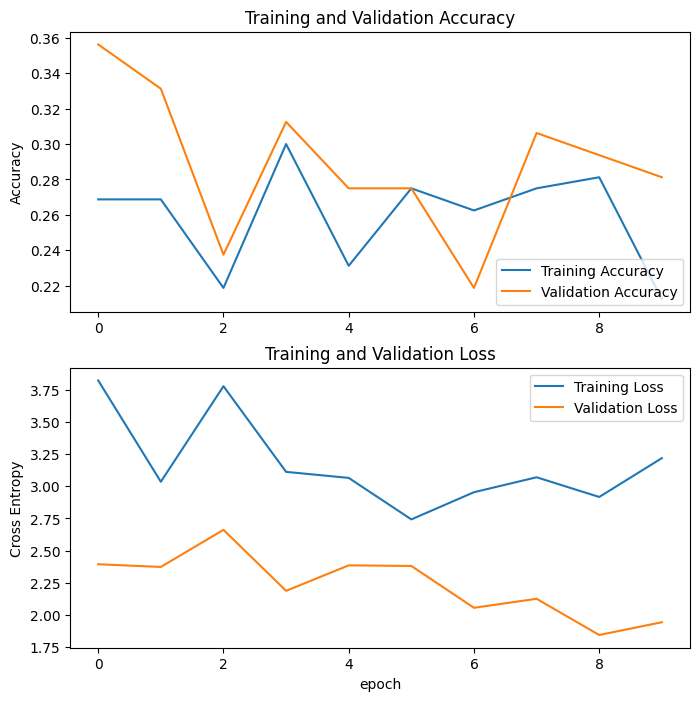

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [15]:
# TODO: FINE TUNE THE MODEL
base_model.trainable = True

In [16]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [21]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 1280)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        10,248 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,288,730 (8.73 MB)

 Trainable params: 1,871,688 (7.14 MB)

 Non-trainable params: 396,544 (1.51 MB)

 Optimizer params: 20,498 (80.07 KB)

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [18]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         steps_per_epoch=5,
                         validation_data=validation_dataset,
                         validation_steps=5)

Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.3168 - loss: 5.2882 - val_accuracy: 0.3187 - val_loss: 1.5486
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 952ms/step - accuracy: 0.3675 - loss: 5.0299 - val_accuracy: 0.3313 - val_loss: 1.5418
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 864ms/step - accuracy: 0.3191 - loss: 5.6453 - val_accuracy: 0.3000 - val_loss: 1.7039
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 832ms/step - accuracy: 0.3111 - loss: 4.8787 - val_accuracy: 0.3438 - val_loss: 2.3672
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 950ms/step - accuracy: 0.1994 - loss: 6.5390 - val_accuracy: 0.3125 - val_loss: 2.8726
Epoch 16/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 866ms/step - accuracy: 0.3470 - loss: 4.6170 - val_accuracy: 0.3250 - val_loss: 2.1709
Epoch 17/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 857ms/step - accuracy: 0.3349 - loss: 6.5358 - val_accuracy: 0.3187 - val_loss: 2.8490
Epoch 18/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 859ms/step - accuracy: 0.3889 - loss: 4.6288 - val_accuracy: 0.3187 - val

In [19]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

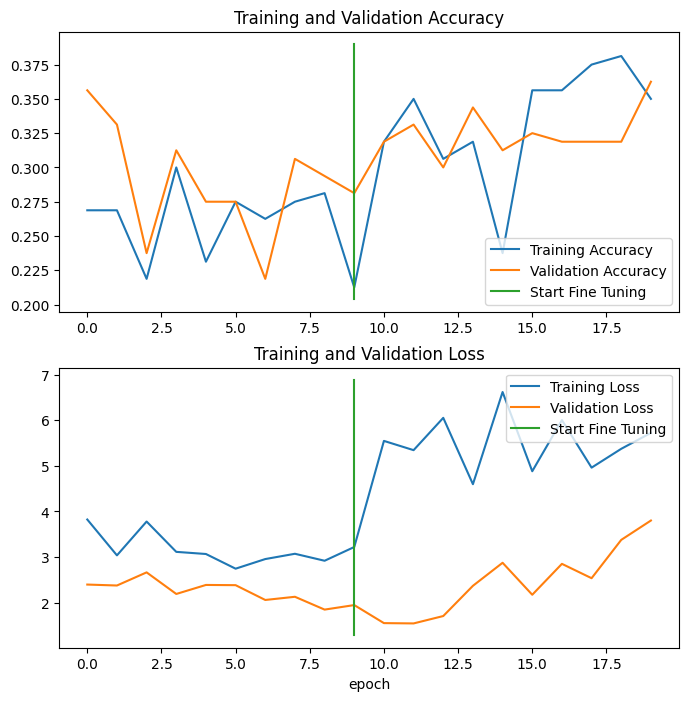

In [20]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 285ms/step - accuracy: 0.3389 - loss: 3.3479
Test accuracy : 0.3386824429035187


In [67]:
class_names = train_dataset.class_names

# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()

array([0.2512615 , 0.10064583, 0.07594016, 0.06436457, 0.08116884],
      dtype=float32)

In [26]:
# Apply a sigmoid since our model returns logits
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.nn.softmax(predictions, axis=-1)
predictions

<tf.Tensor: shape=(256,), dtype=float32, numpy=
array([0.0034515 , 0.00346822, 0.00362273, 0.00358791, 0.00348756,
       0.00734273, 0.00349149, 0.00339317, 0.00341487, 0.00381901,
       0.0044689 , 0.00340341, 0.00364091, 0.00402871, 0.00472147,
       0.00343632, 0.00339548, 0.00547164, 0.00369739, 0.0034671 ,
       0.00371144, 0.00399411, 0.00383642, 0.00348513, 0.00338927,
       0.0034472 , 0.00341682, 0.0035779 , 0.00537366, 0.00377105,
       0.0047117 , 0.0034614 , 0.00346282, 0.00341121, 0.0035617 ,
       0.00340586, 0.0061661 , 0.00437538, 0.0036005 , 0.00339137,
       0.00355273, 0.00342911, 0.00394196, 0.00355956, 0.00544583,
       0.00408116, 0.00363313, 0.00341985, 0.00339192, 0.00341765,
       0.00341594, 0.00397896, 0.00430879, 0.00488221, 0.00418853,
       0.00340017, 0.00359821, 0.00369417, 0.00357808, 0.0035437 ,
       0.00499318, 0.00382879, 0.00425657, 0.00344173, 0.00338991,
       0.003432  , 0.0034352 , 0.00354858, 0.00343714, 0.00375543,
       0.00759